In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['train.csv', 'test.csv', 'sample_submission.csv']


In [2]:
!pip3 install pyro-ppl

    100% |████████████████████████████████| 235kB 19.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 23.4MB/s ta 0:00:01
    100% |████████████████████████████████| 676.9MB 38kB/s  eta 0:00:01         | 187.9MB 31.2MB/s eta 0:00:16    28% |█████████                       | 191.3MB 26.3MB/s eta 0:00:19    | 396.3MB 48.1MB/s eta 0:00:06    58% |██████████████████▉             | 398.3MB 10.5MB/s eta 0:00:27    58% |██████████████████▉             | 398.6MB 10.0MB/s eta 0:00:28    60% |███████████████████▍            | 410.0MB 27.2MB/s eta 0:00:10    78% |█████████████████████████       | 530.9MB 11.1MB/s eta 0:00:14
  Stored in directory: /tmp/.cache/pip/wheels/37/6b/8b/8d15c6042ed38db155158baf56c1949a6e12d5d709697b0c37
  Stored in directory: /tmp/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninst

In [13]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

import torch

pyro.set_rng_seed(0)

In [6]:
train_df = pd.read_csv('../input/train.csv', index_col='id')
test_df = pd.read_csv('../input/test.csv', index_col='id')

In [7]:
train_df.head()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,...,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,...,0.971,-1.489,0.530,0.917,-0.094,-1.407,0.887,-0.104,-0.583,1.267,-1.667,-2.771,-0.516,1.312,0.491,0.932,2.064,0.422,1.215,2.012,0.043,-0.307,-0.059,1.121,1.333,0.211,1.753,0.053,1.274,-0.612,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,-0.152,...,-0.540,-0.299,1.074,-0.748,1.086,-0.766,-0.931,0.432,1.345,-0.491,-1.602,-0.727,0.346,0.780,-0.527,-1.122,-0.208,-0.730,-0.302,2.535,-1.045,0.037,0.020,1.373,0.456,-0.277,1.381,1.843,0.749,0.202,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,-0.732,...,-0.083,-0.831,1.251,-0.206,-0.933,-1.215,0.281,0.512,-0.424,0.769,0.223,-0.710,2.725,0.176,0.845,-1.226,1.527,-1.701,0.597,0.150,1.864,0.322,-0.214,1.282,0.408,-0.910,1.020,-0.299,-1.574,-1.618,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,1.173,...,-1.050,-0.347,0.904,-1.324,-0.849,3.432,0.222,0.416,0.174,-1.517,-0.337,0.055,-0.464,0.014,-1.073,0.325,-0.523,-0.692,0.190,-0.883,-1.830,1.408,2.319,1.704,-0.723,1.014,0.064,0.096,-0.775,1.845,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [23]:
N = train_df.shape[0] # number of training examples

In [24]:
features = [col for col in train_df.columns if col.isdigit()]
target = 'target'

In [25]:
X = torch.tensor(train_df[features].values, dtype=torch.get_default_dtype())
y = torch.tensor(train_df[target].values, dtype=torch.get_default_dtype())

In [26]:
num_inducing = 50

Xu = stats.resample(X.clone(), num_inducing)

In [27]:
kernel = gp.kernels.RBF(input_dim=300, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
likelihood = gp.likelihoods.Binary()

In [28]:
gpmodule = gp.models.VariationalSparseGP(X, y, kernel, Xu,
                                         likelihood=likelihood,
                                         jitter=1e-5)

In [29]:
num_steps = 2500

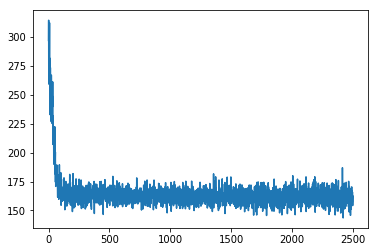

In [30]:
losses = gp.util.train(gpmodule, num_steps=num_steps)
plt.plot(losses);

In [71]:
correct = 0
with torch.no_grad():
    f_loc, f_var = gpmodule(X, full_cov=True)
    # use its likelihood to give prediction class
    pred = gpmodule.likelihood(f_loc, f_var.diag())
    # compare prediction and target to count accuaracy
    correct += pred.eq(y).long().cpu().sum()

In [74]:
print('train accuracy: ', correct.numpy() / N)

train accuracy:  0.64


In [75]:
X_test = torch.tensor(test_df[features].values, dtype=torch.get_default_dtype())

In [76]:
with torch.no_grad():
    f_loc, f_var = gpmodule(X_test, full_cov=True)
    # use its likelihood to give prediction class
    pred = gpmodule.likelihood(f_loc, f_var.diag())
    # compare prediction and target to count accuaracy

In [ ]:
test_predictions = pred.numpy()

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(250,20000),
    'target': test_predictions
})
submission.to_csv("submission.csv", index=False)